# Linear NN for images


## Imports


In [1]:
import os 
import pathlib
import torch 
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader


## Constants


In [2]:
IMG_HEIGTH = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

CLASS_NAMES = np.array(torchvision.datasets.Flowers102.classes)



## TO DO


1. Load the dataset
2. JPEG to rgb
3. scale to 0-1
4. resize to 244*244*3
5. sanity check


In [3]:
# !pip install scipy
    

In [4]:
# The dataset we are going to use is Oxford Flowers 102
# we will use the torchvision.datasets to load the dataset 
# intially the torchvision.datasets.Flower102 return a image path not tensors 
# we will use the loader = torchvision.io.decode_image to convert the raw bytes stream to tensor in CHW format
# the root path - this check if the dataset is already present or else do we need to dowload it 

# We will also need to transform the image as per our requirements 

def one_hot_encode(x):
    return F.one_hot(torch.tensor(x), num_classes=102)

flower_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMG_HEIGTH, IMG_WIDTH)),
    torchvision.transforms.ToTensor(),
])

train_dataset = torchvision.datasets.Flowers102(
    root = "Data/train/", 
    download=True,
    split= "train",
    # loader= torchvision.io.decode_image,
    transform= flower_transform, 
    # target_transform= one_hot_encode
)




In [5]:
val_dataset = torchvision.datasets.Flowers102(
    root = "Data/eval/", 
    download=True,
    split= "val",
    # loader= torchvision.io.decode_image,
    transform= flower_transform, 
    # target_transform= one_hot_encode
)


In [6]:
train_loader = DataLoader(
    dataset= train_dataset,
    batch_size= 16,
    shuffle= True, 
    num_workers= 0,
)

val_loader = DataLoader(
    dataset= val_dataset,
    batch_size= 16,
    shuffle= True, 
    num_workers= 0,
)



In [8]:
# x = torch.tensor(0)
# for img, label in train_dataset:
#     plt.imshow(img.permute(1, 2, 0).numpy())
#     print(img.shape, img.dtype, label.shape, label.dtype)
#     break


In [9]:
# Lets build a linear model for image classification 
# Flatten the image 
# Dense fully connected layer
# Softmax 


!<img src="assest/image.png" height="500" col>

In [10]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [11]:
class ModelV1(nn.Module):
    def __init__(self, in_features, out_features, bias=True, device=DEVICE):
        super().__init__()
        self.Linear = nn.Linear(
            in_features= in_features,
            out_features= out_features, 
            bias= bias,
            device= device
        )
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.flatten(x)
        # print(x.shape, x.ndim)
        x = self.Linear(x)
        # print(x.shape, x.ndim)
        return x
    


        


In [12]:
model = ModelV1(
    in_features=224*224*3, 
    out_features=102,
    bias=True,
    device=DEVICE
)
model


ModelV1(
  (Linear): Linear(in_features=150528, out_features=102, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [13]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.1)


In [34]:
EPOCHS = 50
loss_per_epoch = []

for epoch in range(EPOCHS):
    model.train()
    batch_losses = []
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        # Forward pass
        y_pred = model(x)
        # Shape of y_pred (16, 102)
        # the y_preds are logits we will get the probabilities of the logits 
        # this is taken care inside of the loss_fn
        loss = loss_fn(y_pred, y)

        
        optim.zero_grad()
        # Backward pass
        loss.backward()
        
        # Optimizer step
        optim.step()

        batch_losses.append(loss.item())

    avg_loss = sum(batch_losses) / len(batch_losses)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")
    loss_per_epoch.append(avg_loss)


Epoch 1/50, Loss: 1502.3122
Epoch 2/50, Loss: 1638.7358
Epoch 3/50, Loss: 1054.3946
Epoch 4/50, Loss: 1104.5648
Epoch 5/50, Loss: 1119.6069
Epoch 6/50, Loss: 1180.9237
Epoch 7/50, Loss: 975.1878
Epoch 8/50, Loss: 994.0001
Epoch 9/50, Loss: 854.0326
Epoch 10/50, Loss: 665.7582
Epoch 11/50, Loss: 643.6660
Epoch 12/50, Loss: 660.0657
Epoch 13/50, Loss: 790.3192
Epoch 14/50, Loss: 783.9076
Epoch 15/50, Loss: 621.1813
Epoch 16/50, Loss: 804.3174
Epoch 17/50, Loss: 641.1059
Epoch 18/50, Loss: 882.5303
Epoch 19/50, Loss: 1008.4767
Epoch 20/50, Loss: 1002.6004
Epoch 21/50, Loss: 447.0732
Epoch 22/50, Loss: 362.2789
Epoch 23/50, Loss: 319.1357
Epoch 24/50, Loss: 256.2220
Epoch 25/50, Loss: 410.3790
Epoch 26/50, Loss: 456.4258
Epoch 27/50, Loss: 380.1931
Epoch 28/50, Loss: 508.3502
Epoch 29/50, Loss: 684.8452
Epoch 30/50, Loss: 347.5168
Epoch 31/50, Loss: 204.9462
Epoch 32/50, Loss: 490.7810
Epoch 33/50, Loss: 496.7004
Epoch 34/50, Loss: 486.6208
Epoch 35/50, Loss: 456.1926
Epoch 36/50, Loss: 39

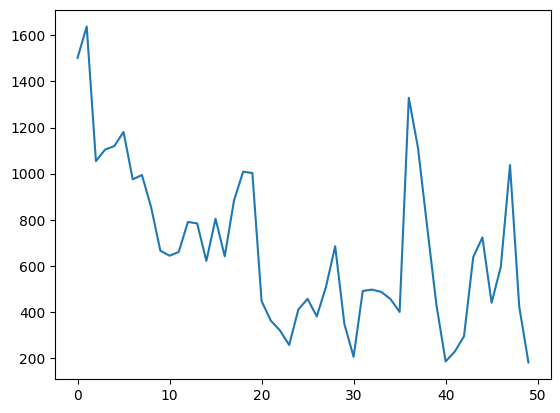

In [37]:
plt.plot(loss_per_epoch)


In [35]:
pred_class_name_per_batch = []
pred_class_idx_pre_batch = []
import torchmetrics

acc = torchmetrics.Accuracy(task='multiclass', num_classes=102, )
# Run inference
with torch.no_grad():
    for img, label in val_loader:
        acc.average
        img, label = img.to(DEVICE), label.to(DEVICE)
        logits = model(img)
        probs = torch.softmax(logits, dim = 1)
        pred_class_idx = torch.argmax(probs, dim=1)
        pred_class_name = CLASS_NAMES[pred_class_idx.to('cpu')]
        pred_class_idx_pre_batch.append(pred_class_idx.to('cpu'))
        pred_class_name_per_batch.append(pred_class_name)
        acc.update( pred_class_idx.to('cpu'), label.to('cpu'))
       

val_acc = acc.compute()
print(f"Validation Accuracy: {val_acc.item() * 100:.2f}%")


Validation Accuracy: 10.49%


In [ ]:
# import torchmetrics
# batch = next(iter(val_loader))
# img , label = batch
# for i in range(16):
#     print(f"Predicted class index: {pred_class_idx_pre_batch[0][i]}")
#     print(f"Predicted class name: {pred_class_name_per_batch[0][i]}")
#     print(f"True label index: {label[i]}")
#     print(f"True label name: {CLASS_NAMES[label[i]]}")





## How to improve the model 

We can see the accuracy of our model is very low 
some ways we can imporve our model are
1. using deeper neural network 
2. using activation functions 
3. using convolution layers 
